In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [4]:
raw=[]
for subdir, root, files in os.walk('drive/My Drive/Data_mining_project/BSE_BET_DATA/files'):
    for file in files:
        #print os.path.join(subdir, file)y
        filepath = subdir + os.sep + file

        raw.append(filepath)
print(raw)
raw1=pd.DataFrame (raw, columns = ['Filename'])
brain=pd.read_csv('drive/My Drive/Data_mining_project/BSE_BET_DATA/labels.csv')
brain["Resized"]='drive/My Drive/Data_mining_project/BSE_BET_DATA/resized/' + brain['Filename'].astype(str)+'.gz'
brain['Filename'] = 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/' + brain['Filename'].astype(str)+'.gz'
# brain.loc[~((brain.Filename.isin(raw['Filename']))),:]
# brain.merge(raw1, on='Filename', how='left')
brain = pd.merge(brain, raw1, on=['Filename'], how='inner')
print(brain)

['drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI108-Guys-0865-T1_bse_high_s72_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI189-Guys-0799-T1_bse_high_s74_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI626-Guys-1094-T1_bse_high_s76_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI216-HH-1635-T1_bse_high_s73_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI479-Guys-1034-T1_bse_high_s73_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI486-Guys-1005-T1_bse_high_s85_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI532-IOP-1145-T1_bse_high_s77_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI640-Guys-1106-T1_bse_high_s72_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI487-Guys-1037-T1_bse_high_s8_r2.nii.gz', 'drive/My Drive/Data_mining_project/BSE_BET_DATA/files/IXI221-HH-1606-T1_bse_high_s74_r2.nii.gz', 'driv

Shape of image= (128, 128, 64)


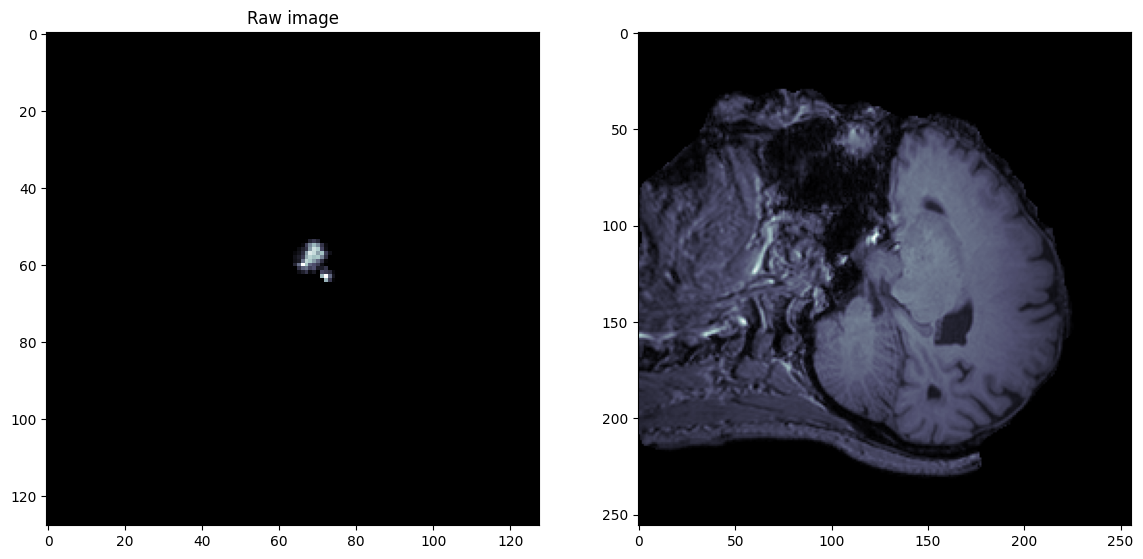

In [5]:
img=process_scan(brain['Filename'][2])

print('Shape of image=',img.shape)
fig,ax=plt.subplots(1,2,figsize=(14,10))
ax[0].set_title('Raw image')
ax[0].imshow(img[:,:,60], cmap='bone')
img1 = nib.load(brain['Filename'][2]).get_fdata()
ax[1].imshow(img1[:,:,60], cmap='bone')

In [ ]:


mir_images = np.array([process_scan(brain['Filename'][i]) for i in range(len(brain)//2)])




In [1]:
mir_labels = np.array([brain['Recognizable-Facial-Feature'][i] for i in range(len(brain))])
my_map={'Yes':1,'No':0}
mir_labels=np.vectorize(my_map.get)(mir_labels)
print(mir_labels)

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(mir_images, mir_labels, test_size=0.2, random_state=42)
print(y_train)

[1 0 0 ... 0 0 1]


In [ ]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


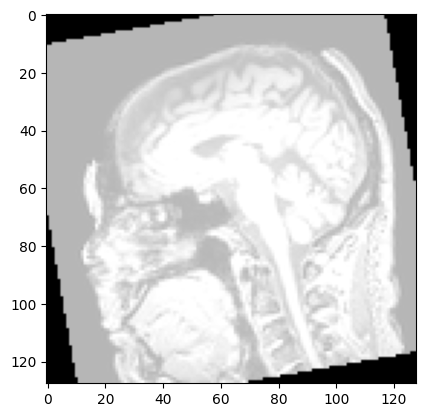

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

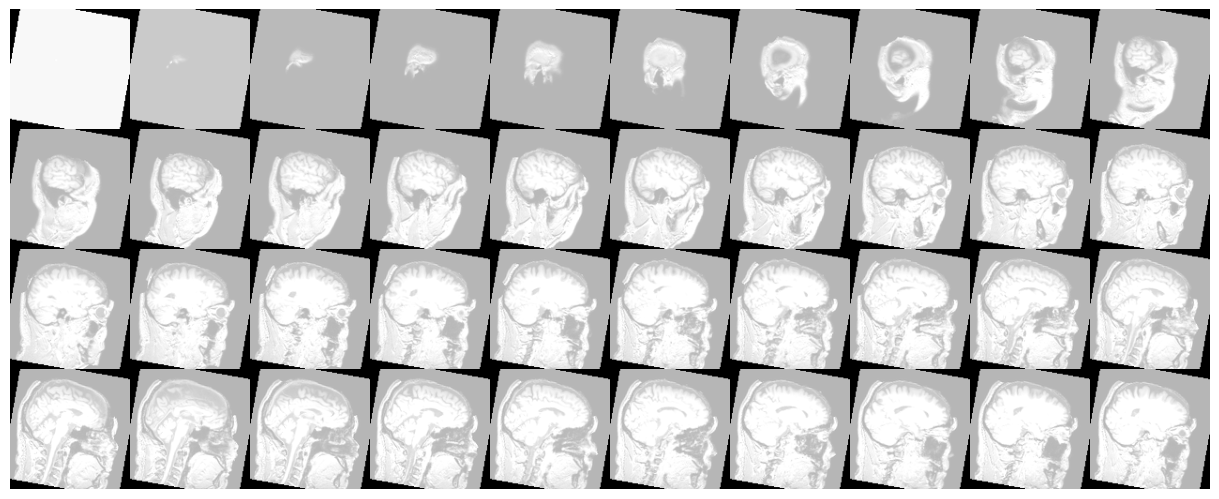

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [ ]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 25
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/25
198/198 - 63s - loss: 0.2477 - acc: 0.8911 - val_loss: 0.0292 - val_acc: 0.9899 - 63s/epoch - 317ms/step
Epoch 2/25
198/198 - 59s - loss: 0.1979 - acc: 0.9114 - val_loss: 5.2301 - val_acc: 0.6061 - 59s/epoch - 297ms/step
Epoch 3/25
198/198 - 59s - loss: 0.1949 - acc: 0.9291 - val_loss: 0.2459 - val_acc: 0.8586 - 59s/epoch - 296ms/step
Epoch 4/25
198/198 - 59s - loss: 0.1550 - acc: 0.9392 - val_loss: 0.0101 - val_acc: 1.0000 - 59s/epoch - 299ms/step
Epoch 5/25
198/198 - 59s - loss: 0.1721 - acc: 0.9266 - val_loss: 0.0029 - val_acc: 1.0000 - 59s/epoch - 300ms/step
Epoch 6/25
198/198 - 59s - loss: 0.1258 - acc: 0.9620 - val_loss: 1.3690 - val_acc: 0.6162 - 59s/epoch - 299ms/step
Epoch 7/25
198/198 - 59s - loss: 0.1713 - acc: 0.9367 - val_loss: 0.0022 - val_acc: 1.0000 - 59s/epoch - 297ms/step
Epoch 8/25
198/198 - 59s - loss: 0.1751 - acc: 0.9342 - val_loss: 1.0320 - val_acc: 0.6263 - 59s/epoch - 298ms/step
Epoch 9/25
198/198 - 60s - loss: 0.0939 - acc: 0.9544 - val_loss: 0.3927

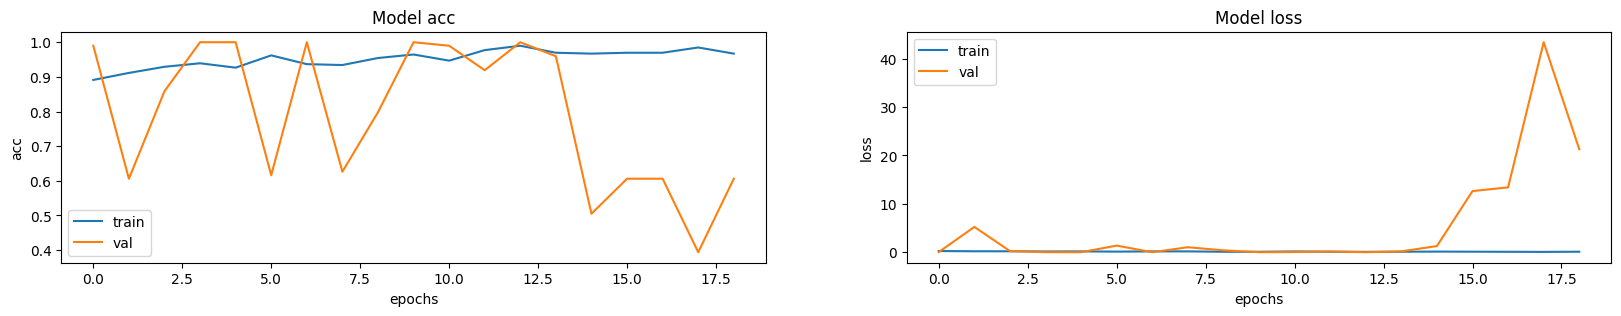

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [ ]:
# Load best weights.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
model1.load_weights("3d_image_classification.h5")
prediction =model1.predict(np.expand_dims(x_val[10], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["Facial"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan has no %s feature loss "
        % ((100 * score), name)
    )

conf_matrix=confusion_matrix(y_true=y_val,y_pred=prediction)

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
  for j in range(conf_matrix.shape[1]):
    ax1.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


NameError: ignored

MODEL FOR BRAIN LOSS 


In [ ]:
mir_labels_brain = np.array([brain['Brain-Feature-Loss'][i] for i in range(len(brain)//4)])
my_map={'Yes':1,'No':0}
mir_labels_brain=np.vectorize(my_map.get)(mir_labels_brain)
print(mir_labels_brain)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
from sklearn.model_selection import train_test_split

x_train1, x_val1, y_train1, y_val1 = train_test_split(mir_images, mir_labels_brain, test_size=0.3, random_state=42)
print(y_train)

[0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1
 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0
 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1
 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1
 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1
 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1
 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1]


In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train1, y_train1))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val1, y_val1))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
def get_model_brainloss(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model1 = keras.Model(inputs, outputs, name="3dcnn")
    return model1


# Build model.
model1 = get_model_brainloss(width=128, height=128, depth=64)
model1.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model1.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification1.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 25
model1.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/25
173/173 - 74s - loss: 0.3708 - acc: 0.7942 - val_loss: 1.9684 - val_acc: 0.4027 - 74s/epoch - 427ms/step
Epoch 2/25
173/173 - 55s - loss: 0.2820 - acc: 0.8638 - val_loss: 0.4325 - val_acc: 0.7450 - 55s/epoch - 319ms/step
Epoch 3/25
173/173 - 55s - loss: 0.2395 - acc: 0.8667 - val_loss: 0.0789 - val_acc: 0.9933 - 55s/epoch - 320ms/step
Epoch 4/25
173/173 - 55s - loss: 0.1783 - acc: 0.9246 - val_loss: 0.0455 - val_acc: 0.9866 - 55s/epoch - 321ms/step
Epoch 5/25
173/173 - 56s - loss: 0.1840 - acc: 0.9159 - val_loss: 0.2197 - val_acc: 0.9329 - 56s/epoch - 326ms/step
Epoch 6/25
173/173 - 55s - loss: 0.1775 - acc: 0.9217 - val_loss: 0.1177 - val_acc: 0.9866 - 55s/epoch - 320ms/step
Epoch 7/25
173/173 - 55s - loss: 0.1575 - acc: 0.9391 - val_loss: 4.2883 - val_acc: 0.5973 - 55s/epoch - 318ms/step
Epoch 8/25
173/173 - 55s - loss: 0.1707 - acc: 0.9362 - val_loss: 0.1795 - val_acc: 0.9799 - 55s/epoch - 315ms/step
Epoch 9/25
173/173 - 55s - loss: 0.1726 - acc: 0.9420 - val_loss: 0.1345

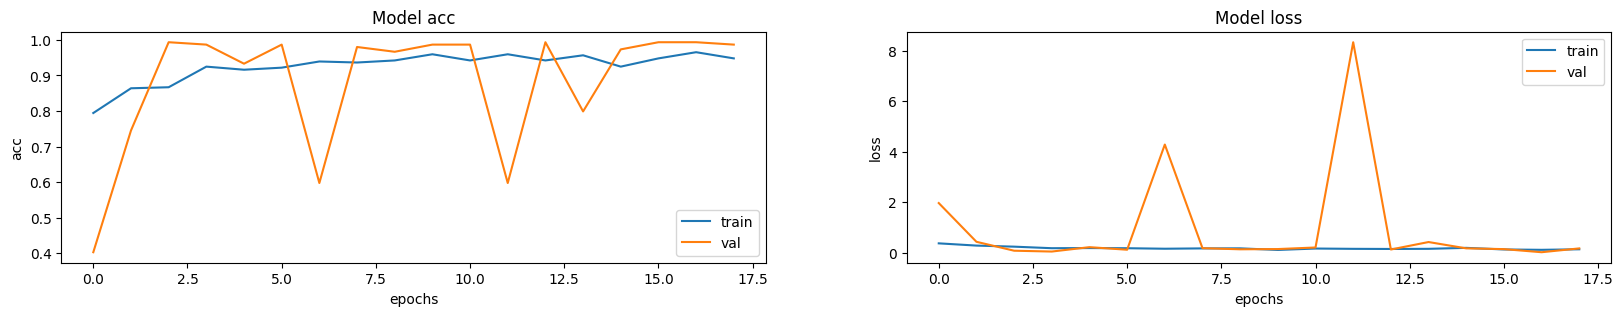

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model1.history.history[metric])
    ax[i].plot(model1.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [ ]:
# Load best weights.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
#model1.load_weights("3d_image_classification.h5")
print(x_val1.shape)
prediction1 =model1.predict(np.expand_dims(x_val1[0], axis=0))[0]
scores1 = [1 - prediction[0], prediction[0]]

class_names = ["Facial"]
for score, name in zip(scores1, class_names):
    print(
        "This model is %.2f percent confident that MRI scan has no %s feature loss "
        % ((100 * score), name)
    )

conf_matrix=confusion_matrix(y_true=y_val1,y_pred=prediction1)

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
  for j in range(conf_matrix.shape[1]):
    ax1.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


(149, 128, 128, 64)
1/1 [==============================] - 0s 25ms/step
This model is 99.10 percent confident that MRI scan has no Facial feature loss 


ValueError: ignored

In [ ]:
1